# Scikit-learn K-Means



https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

### Additional Information

1. date: Date in format dd/mm/yyyy
2. time: time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt) 
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from aux_functions import assign_label, convergence, periodic_mean, myInertia
sns.set_theme()

# from multiprocess import Pool
# from sklearn.model_selection import train_test_split

# Loading and cleaning data

In [2]:
raw_data = pd.read_csv("household_power_consumption.txt", delimiter=';', low_memory=False)

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [4]:
raw_data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


Our first step into cleaning the data formats all the missing data to proper np.NaN, in this way we can check if there are any patterns in the missing data.

In [5]:
raw_data.replace('\?', np.NaN, regex=True, inplace=True)

We correct the Data types found above to more useful ones. Specifically, we want the date and time columns to represent continuous variables that reflect their periodicity. 
We decide to make both of them timedelta into days and seconds respectively. We extract the day of the year and the amount of seconds of the day time. 

In [6]:
raw_data["Date"] = pd.to_datetime(raw_data['Date'], format='%d/%m/%Y')
raw_data["Time"] = pd.to_timedelta(raw_data['Time'])
raw_data['Year'] = pd.to_datetime(raw_data['Date'].dt.year, format='%Y')
raw_data['date_d'] = pd.to_timedelta(raw_data['Date'] - raw_data['Year']).dt.days
raw_data['time_s'] = raw_data['Time'].dt.total_seconds() / (24 * 60 * 60)
# format='%H:%M:%S'

We verify that the missing data is equally distributed throughout the features below.

In [7]:
columns = raw_data.columns
for c in columns[2:9]:
    raw_data[c] = raw_data[c].astype('float64')
    print(raw_data[c].isna().value_counts())


Global_active_power
False    2049280
True       25979
Name: count, dtype: int64
Global_reactive_power
False    2049280
True       25979
Name: count, dtype: int64
Voltage
False    2049280
True       25979
Name: count, dtype: int64
Global_intensity
False    2049280
True       25979
Name: count, dtype: int64
Sub_metering_1
False    2049280
True       25979
Name: count, dtype: int64
Sub_metering_2
False    2049280
True       25979
Name: count, dtype: int64
Sub_metering_3
False    2049280
True       25979
Name: count, dtype: int64


It turns out the missing data corresponds to specific dates were no measurements are available, given the small proportion of data and the lack of a pattern we decide to omit those observations from the data frame.

In [8]:
raw_data.describe()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,date_d,time_s
count,2075259,2075259,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2075259,2.075259e+06,2.075259e+06
mean,2008-12-05 19:13:27.255191040,0 days 11:59:32.744809202,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,2008-06-08 20:10:14.903874560,1.799606e+02,4.996845e-01
min,2006-12-16 00:00:00,0 days 00:00:00,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2006-01-01 00:00:00,0.000000e+00,0.000000e+00
25%,2007-12-12 00:00:00,0 days 06:00:00,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-01-01 00:00:00,9.000000e+01,2.500000e-01
50%,2008-12-06 00:00:00,0 days 12:00:00,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2008-01-01 00:00:00,1.800000e+02,5.000000e-01
75%,2009-12-01 00:00:00,0 days 18:00:00,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2009-01-01 00:00:00,2.700000e+02,7.500000e-01
max,2010-11-26 00:00:00,0 days 23:59:00,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2010-01-01 00:00:00,3.650000e+02,9.993056e-01
std,NaN,0 days 06:55:41.677081176,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,NaN,1.045229e+02,2.886768e-01


In [9]:
null_dates = raw_data[raw_data['Global_active_power'].isna()]['Date'].index
null_times = raw_data[raw_data['Global_active_power'].isna()]['time_s'].index
pd.DataFrame(null_times==null_dates)[0].value_counts()

0
True    25979
Name: count, dtype: int64

In [10]:
raw_data['Global_reactive_power'].replace(0.0,np.NaN,inplace=True)
raw_data['Sub_metering_1'].replace(0.0,5.0e-1,inplace=True)
raw_data['Sub_metering_2'].replace(0.0,5.0e-1,inplace=True)
raw_data['Sub_metering_3'].replace(0.0,5.0e-1,inplace=True)

In [11]:
data = raw_data.dropna()
data = data.drop(columns=['Date','Time'])
print(data.dtypes)

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Year                     datetime64[ns]
date_d                            int64
time_s                          float64
dtype: object


<Axes: >

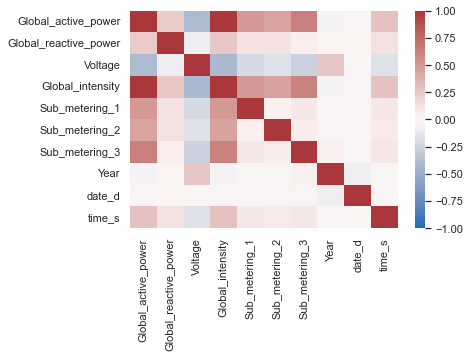

In [12]:
sns.heatmap(data.corr(), cmap="vlag",vmin=-1, vmax=1)

With the information provided by the correlation matrix, we can opt to ignore the features that present weak correlations or that represent obvious collinearity. For this dataset we can easily see that `Global_intensity` and `Global_active_power` contain the same information and we choose to keep `Global_active_power`. We can also observe that the time variables show very weak correlations, but we will study this further later on. The `Sub_metering` features are also very similar among them and we consider only `Sub_metering_3` in what follows. 

In [13]:
data.drop(columns=['Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Year','date_d'], inplace=True)

# Preprocessing data, scaling

In [14]:
list(data.columns)

['Global_active_power', 'Global_reactive_power', 'Sub_metering_3', 'time_s']

In [29]:
for c in ['Global_active_power','Global_reactive_power','Sub_metering_3']:
    data['log_'+ c.lower()] = np.log(data[c])
    data.drop(columns=c, inplace=True)

for c in ['time_s']:
    scaler = MinMaxScaler((-np.pi,np.pi))
    data_to_scale = data[c].to_numpy().reshape(-1,1)
    scaler.fit(data_to_scale)
    data[c] = scaler.transform(data_to_scale)

<Axes: >

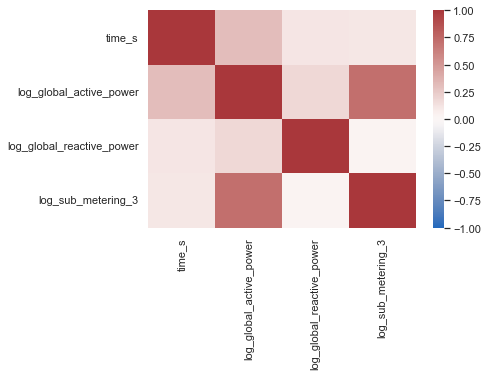

In [30]:
sns.heatmap(data.corr(), cmap="vlag",vmin=-1, vmax=1)

In [31]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1567719 entries, 0 to 2075247
Data columns (total 4 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   time_s                     1567719 non-null  float64
 1   log_global_active_power    1567719 non-null  float64
 2   log_global_reactive_power  1567719 non-null  float64
 3   log_sub_metering_3         1567719 non-null  float64
dtypes: float64(4)
memory usage: 59.8 MB
None


# Scikit Model Training

We perform several fits to a smaller sub-sample using scikit's KMean algo to find the optimal number of clusters by using the "Elbow method".

In [32]:
inertias = []
iterations = []
ks = np.array(range(2,8,1))
for k in ks:
    model = KMeans(n_clusters=k, n_init=20, algorithm='lloyd', max_iter=100, tol=1.0e-5)
    model.fit(data.sample(n=100000))
    inertias.append(model.inertia_)
    iterations.append(model.n_iter_)

[3, 3, 6, 11, 19, 25]


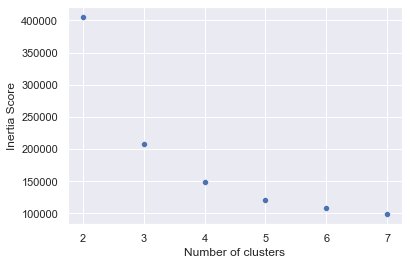

In [33]:
print(iterations)
inertia_df = pd.DataFrame(data={'k_s':ks,'inertia':inertias})
sns.scatterplot(data = inertia_df, x='k_s', y='inertia')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.show()


In [34]:
best_k = 4
model = KMeans(n_clusters=best_k, n_init=100, algorithm='lloyd',max_iter=100)
model.fit(data)
print(model.inertia_)
print(model.n_iter_)

2333989.7613734314
5


In [35]:
labels = pd.DataFrame(model.labels_)
print(labels.value_counts())
print(labels.info())

2    521268
1    466090
3    338937
0    241424
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567719 entries, 0 to 1567718
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   0       1567719 non-null  int32
dtypes: int32(1)
memory usage: 6.0 MB
None


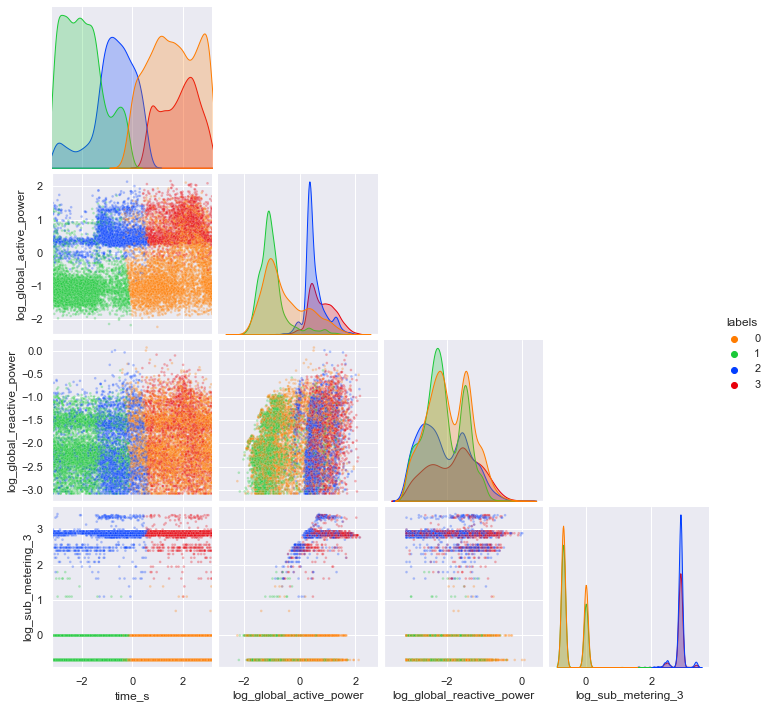

In [56]:
data_labeled = data.copy()
data_labeled['labels'] = labels.values
data_sample = data_labeled.sample(n=int(len(data_labeled)/100))
sns.set_theme()
plot_columns = list(data_sample.columns)
plot_columns.remove('labels')
plot_columns.remove('log_global_active_power')
colors = sns.color_palette("bright")[:best_k]
ax = sns.pairplot(data=data_sample, hue='labels',plot_kws={'s':7,'alpha':.3},corner=True,palette=[colors[1],colors[2],colors[0],colors[3]])
ax.axes[3,0].set_xlim((-np.pi,np.pi))
plt.savefig('def_kmeans_n4.png')
plt.show()

Is it worth exploring the impact of the date?
Given weather variations it probably makes sense to include it...
Testing below seems not to show any clustering advantage.

![image.png|300](def_kmeans_date.png)

We can further analyze the date on a yearly basis to gain more insight, the plot above does some "waviness" corresponding to year.

Another idea concerns making the time periodic, it seems like usage at night might be false distant from usage in the morning. Consider using noon as time reference for the time-deltas.

# Periodic clustering implementation

In order to account for the periodic nature of variables related to time. We implement a K-Means algorithm using a periodic distance and mean. Inspired in the publication: 

Miniak-Górecka, A.; Podlaski, K.; Gwizdałła, T. *Using K-Means Clustering in Python with Periodic Boundary Conditions*. Symmetry 2022, 14, 1237. https://doi.org/10.3390/sym14061237 


In [14]:
def myKmeans(df, n_vars_per=0, n_clusters=2, n_init=10, tol=1.e-2, iter_max=15):
    n_features = len(df.columns)
    centroids = np.zeros((n_clusters,n_features))
    new_centroids = np.zeros((n_clusters,n_features))
    numpy_data = df.to_numpy()
    
    init_centroids = []
    inertias = []
    for i in range(n_init):
        temp_centroids = np.zeros((n_clusters,n_features))
        for i in range(n_clusters):
            centroid_coords = np.zeros(n_features)
            for j in range(n_features):
                centroid_coords[j] = np.random.uniform(df[df.columns[j]].min(),df[df.columns[j]].max())
            temp_centroids[i] = centroid_coords
        init_centroids.append(temp_centroids)
        inertias.append(myInertia(temp_centroids,numpy_data,n_vars_per))
    
    best_index = np.argmin(inertias)
    new_centroids = init_centroids[best_index]
    print('Initial centroids below from attempt: {}'.format(best_index+1))
    print(new_centroids)
    print('Initial inertia: {}'.format(myInertia(new_centroids,numpy_data,n_vars_per)))

    labels = []
    iter = 0    
    while (convergence(new_centroids, centroids,n_vars_per) > tol) and (iter<=iter_max):
        print('---------------------------------------------')
        centroids = new_centroids.copy()
        labels = []
        for row in numpy_data:
            labels.append(assign_label(row, new_centroids, n_vars_per))
        
        for i in range(n_clusters):
            cluster_elem_index = [j for j in range(len(labels)) if labels[j] == i]
            cluster = np.array([numpy_data[j] for j in cluster_elem_index])
            pre_centroid = np.mean(cluster, axis=0)
            for j in range(n_vars_per):
                pre_centroid[j] = periodic_mean(cluster[:,j])
            new_centroids[i] = pre_centroid

        
        print('Iteration number: {}\n Centroids below: '.format(iter))
        print(new_centroids)
        print('Current inertia: {}'.format(myInertia(new_centroids,numpy_data,n_vars_per)))
        iter += 1

    # pool.close()
    return labels, new_centroids

## Including time of the day 

In [16]:
data = raw_data.dropna()
data = data.drop(columns=['Date','Time'])
print(data.dtypes)

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Year                     datetime64[ns]
date_d                            int64
time_s                          float64
dtype: object


In [17]:
data.drop(columns=['Global_intensity','Global_reactive_power','Sub_metering_1','Sub_metering_2','Year','date_d','Sub_metering_3'], inplace=True)

In [18]:
for c in ['Global_active_power','Voltage']:
    data['log_'+ c.lower()] = np.log(data[c])
    data.drop(columns=c, inplace=True)

for c in ['time_s','log_voltage']:
    scaler = MinMaxScaler((-np.pi,np.pi))
    data_to_scale = data[c].to_numpy().reshape(-1,1)
    scaler.fit(data_to_scale)
    data[c] = scaler.transform(data_to_scale)

In [29]:
best_k = 3
test_sample = data.sample(n=400000)
labeled_df, centroids = myKmeans(test_sample,n_vars_per=1,n_clusters=best_k,n_init=10,tol=1.e-03,iter_max=30)

Initial centroids below from attempt: 6
[[-0.93408976  1.63289409  5.5264442 ]
 [ 2.55752854 -1.04451766  5.45898077]
 [-0.79735382 -0.13292119  5.48630537]]
Initial inertia: 746289.837311765
Displacement of centroids: 3.370886474032117
---------------------------------------------
Iteration number: 0
 Centroids below: 
[[-0.34349053  1.17305788  5.47415184]
 [ 2.4961768  -0.36147143  5.48423026]
 [-0.58493492 -0.33867336  5.48408209]]
Current inertia: 582553.3725200219
Displacement of centroids: 0.352988147948719
---------------------------------------------
Iteration number: 1
 Centroids below: 
[[-0.03218128  0.76985773  5.47941515]
 [ 2.53256218 -0.27832147  5.4839483 ]
 [-0.78093366 -0.67821594  5.48467905]]
Current inertia: 516395.22049129114
Displacement of centroids: 0.21639840526580462
---------------------------------------------
Iteration number: 2
 Centroids below: 
[[-0.05533651  0.60484693  5.47931613]
 [ 2.5102031  -0.25736922  5.48373805]
 [-1.07902384 -0.95038603  5.48

399076.18325020804
0    141413
1    138059
2    120528
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       400000 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB
None


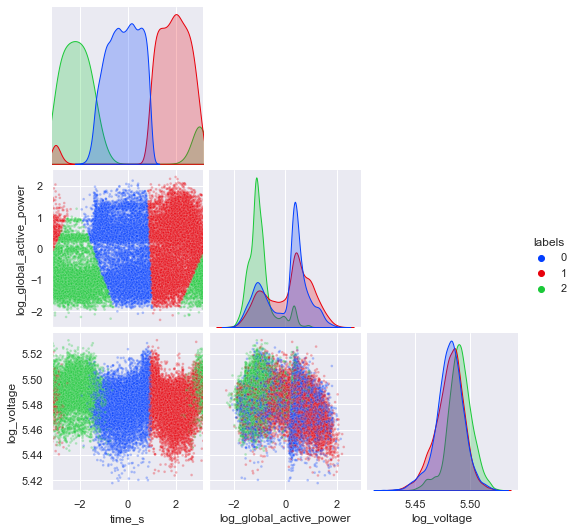

In [34]:
print(myInertia(centroids,test_sample.to_numpy(),1))
labels = pd.DataFrame(labeled_df)
print(labels.value_counts())
print(labels.info())
data_labeled = test_sample.copy()
data_labeled['labels'] = labels.values
data_sample = data_labeled.sample(n=int(len(data_labeled)/10))
colors = sns.color_palette("bright")
ax = sns.pairplot(data=data_sample, hue='labels',plot_kws={'s':7,'alpha':.3},corner=True,palette=[colors[0],colors[3],colors[2]])
ax.axes[2,0].set_xlim((-np.pi,np.pi))
plt.savefig('periodic_time_n3.png')
plt.show()


### Including 1 more feature

In [35]:
data = raw_data.dropna()
data = data.drop(columns=['Date','Time'])
print(data.dtypes)

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Year                     datetime64[ns]
date_d                            int64
time_s                          float64
dtype: object


In [36]:
data.drop(columns=['Global_intensity','Global_reactive_power','Sub_metering_1','Sub_metering_2','Year','date_d'], inplace=True)
for c in ['Global_active_power','Voltage','Sub_metering_3']:
    data['log_'+ c.lower()] = np.log(data[c])
    data.drop(columns=c, inplace=True)

for c in ['time_s','log_voltage']:
    scaler = MinMaxScaler((-np.pi,np.pi))
    data_to_scale = data[c].to_numpy().reshape(-1,1)
    scaler.fit(data_to_scale)
    data[c] = scaler.transform(data_to_scale)

In [37]:
best_k = 3
test_sample = data.sample(n=400000)
labeled_df, centroids = myKmeans(test_sample,n_vars_per=1,n_clusters=best_k,n_init=10,tol=1.e-03,iter_max=30)

Initial centroids below from attempt: 6
[[ 1.27288554  0.50167191  0.66105119  0.20387372]
 [-1.67573891  2.36505154  1.37549656  2.21211997]
 [-0.34707286  0.17083216  1.21413299  0.3210573 ]]
Initial inertia: 2203048.2528103287
Displacement of centroids: 1.2670286967388686
---------------------------------------------
Iteration number: 0
 Centroids below: 
[[ 1.94798126 -0.20831953  0.48337753  0.42245004]
 [-1.09594895  0.68113149  0.34492569  2.89020723]
 [-1.16185742 -0.78027443  0.74669083  0.10582557]]
Current inertia: 1139836.1016842667
Displacement of centroids: 0.794046172172213
---------------------------------------------
Iteration number: 1
 Centroids below: 
[[ 1.99653397 -0.28291425  0.53942806  0.12481202]
 [-0.25963108  0.60314878  0.348773    2.87582703]
 [-1.59466012 -1.00251953  0.76044785 -0.44258715]]
Current inertia: 948747.9932691489
Displacement of centroids: 0.33454435065442406
---------------------------------------------
Iteration number: 2
 Centroids below:

In [44]:
print(myInertia(centroids,test_sample.to_numpy(),1))
labels = pd.DataFrame(labeled_df)
print(labels.value_counts())
print(labels.info())
data_labeled = test_sample.copy()
data_labeled['labels'] = labels.values


828966.8517113714
1    146864
2    132554
0    120582
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       400000 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB
None


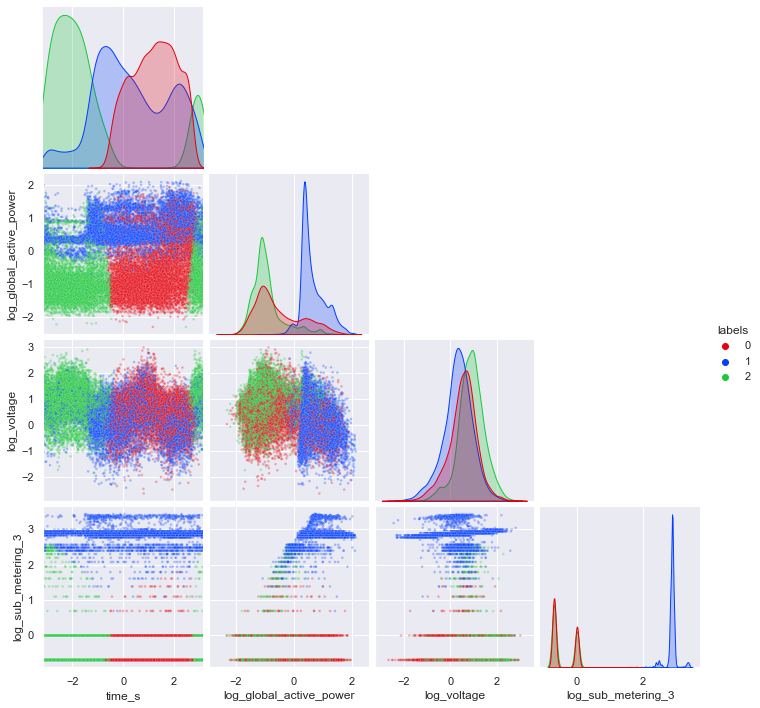

In [46]:
data_sample = data_labeled.sample(n=int(len(data_labeled)/10))
colors = sns.color_palette("bright")
ax = sns.pairplot(data=data_sample, hue='labels',plot_kws={'s':7,'alpha':.3},corner=True,palette=[colors[3],colors[0],colors[2]])
ax.axes[2,0].set_xlim((-np.pi,np.pi))
plt.savefig('periodic_time_n3_f4.png')
plt.show()

## Including time of the day and day of the year

In [15]:
data = raw_data.dropna()
data = data.drop(columns=['Date','Time'])
print(data.dtypes)

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
Year                     datetime64[ns]
date_d                            int64
time_s                          float64
dtype: object


In [16]:
data.drop(columns=['Global_intensity','Global_reactive_power','Sub_metering_1','Sub_metering_2','Year'], inplace=True)

In [17]:
for c in ['Global_active_power','Voltage','Sub_metering_3']:
    data['log_'+ c.lower()] = np.log(data[c])
    data.drop(columns=c, inplace=True)

# for c in ['log_voltage']:
#     scaler = StandardScaler()
#     data_to_scale = data[c].to_numpy().reshape(-1,1)
#     scaler.fit(data_to_scale)
#     data[c] = scaler.transform(data_to_scale)

for c in ['date_d','time_s','log_voltage']:
    scaler = MinMaxScaler((-np.pi,np.pi))
    data_to_scale = data[c].to_numpy().reshape(-1,1)
    scaler.fit(data_to_scale)
    data[c] = scaler.transform(data_to_scale)

### Fitting to k=3 cluster

In [29]:
best_k = 3
test_sample = data.sample(n=800000)
labeled_df, centroids = myKmeans(test_sample,n_vars_per=2,n_clusters=best_k,n_init=10,tol=1e-3,iter_max=60)

Initial centroids below from attempt: 3
[[-2.53353867  1.8647567   0.36488614  0.51071104 -0.4201115 ]
 [ 2.32712145  1.09200707 -1.55408668 -3.04604377  0.92045479]
 [ 2.93532557 -2.35337181  0.42735857  1.01554016  1.95712022]]
Initial inertia: 6887210.399284955
Displacement of centroids: 1.8039613385696125
---------------------------------------------
Iteration number: 0
 Centroids below: 
[[-0.75299276  2.09069175 -0.64079351  0.65366986 -0.38455339]
 [ 0.57192906  0.243286   -0.96374997 -0.76126323  0.30839144]
 [ 2.19501653 -0.9425131   0.21189271  0.47236317  2.08858972]]
Current inertia: 5047396.655798489
Displacement of centroids: 1.0613256869655714
---------------------------------------------
Iteration number: 1
 Centroids below: 
[[-1.0842606   2.7452928  -0.59834984  0.73137331 -0.22325814]
 [ 0.81857004 -0.03442647 -0.82394839  0.30509458 -0.14294546]
 [ 2.83002063 -0.42461425  0.46000413  0.45999425  2.43304133]]
Current inertia: 4124692.5312410314
Displacement of centro

In [30]:
print(myInertia(centroids,test_sample.to_numpy(),2))
labels = pd.DataFrame(labeled_df)
print(labels.value_counts())
print(labels.info())
data_labeled = test_sample.copy()
data_labeled['labels'] = labels.values

3721433.1173727186
1    282409
2    280483
0    237108
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       800000 non-null  int64
dtypes: int64(1)
memory usage: 6.1 MB
None


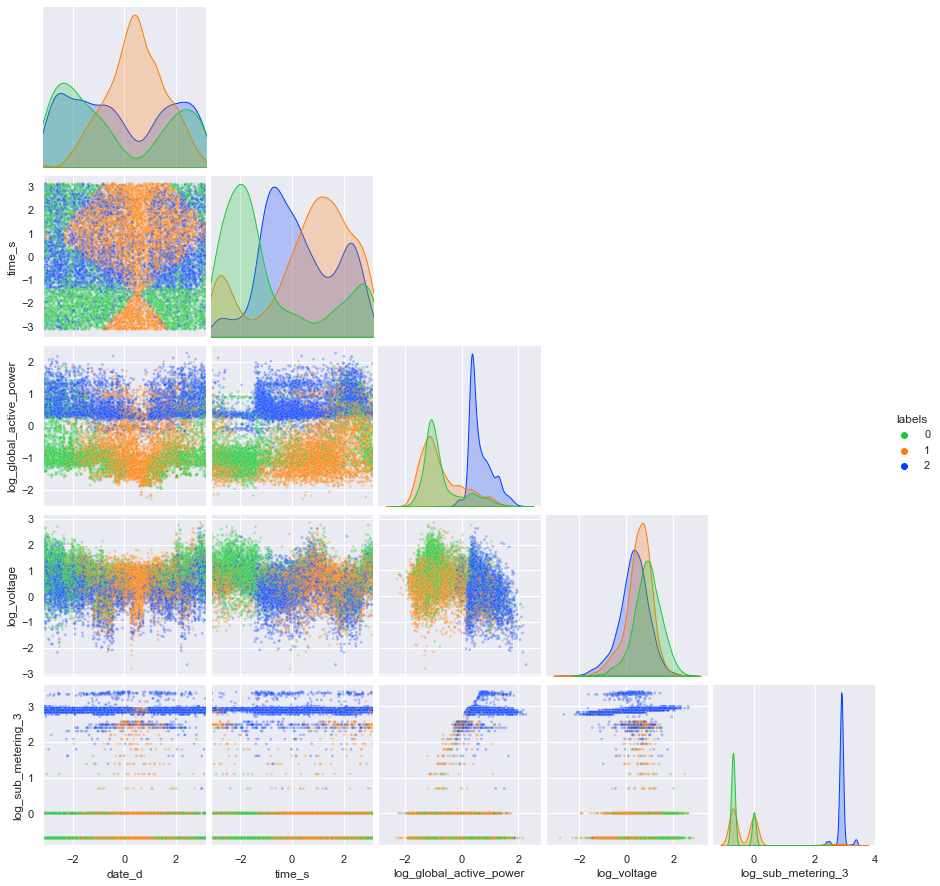

In [32]:
data_sample = data_labeled.sample(n=int(len(data_labeled)/50))
colors = sns.color_palette("bright")
ax = sns.pairplot(data=data_sample, hue='labels',plot_kws={'s':8,'alpha':.3},corner=True,palette=[colors[2],colors[1],colors[0]])
ax.axes[4,0].set_xlim((-np.pi,np.pi))
ax.axes[4,1].set_xlim((-np.pi,np.pi))
plt.savefig('periodic_date_time_n3_v2.png')
plt.show()

### Fitting to k=4 clusters

In [18]:
best_k = 4
test_sample = data.sample(n=800000)
labeled_df, centroids = myKmeans(test_sample,n_vars_per=2,n_clusters=best_k,n_init=20,tol=1e-4,iter_max=60)

Initial centroids below from attempt: 16
[[-2.29410737 -1.83293036 -2.15867353  1.10678859  0.54627409]
 [ 2.49643753  1.85488819  1.87235777  2.28206052  0.99133054]
 [ 0.49125844 -1.38805475 -0.5273536   1.39577658 -0.22088042]
 [ 0.66831968  1.34523004  0.63887909 -1.28476519  1.93132581]]
Initial inertia: 5868085.268555468
Displacement of centroids: 1.5274671260515968
---------------------------------------------
Iteration number: 0
 Centroids below: 
[[-2.31478764 -2.19059173 -0.74502984  0.98384475 -0.06277449]
 [-3.03669375  1.64377501  0.57948241  0.80812638  1.38304742]
 [ 0.53601934 -2.04063933 -0.89602648  0.64976273 -0.28832879]
 [ 0.23778034  0.69541013  0.56768098  0.04157556  2.46422398]]
Current inertia: 3747579.4434137265
Displacement of centroids: 0.7381777878176197
---------------------------------------------
Iteration number: 1
 Centroids below: 
[[-2.28469262 -2.39943207 -0.72904407  1.00425448 -0.47808478]
 [-3.02390526  1.36552227  0.39184686  0.56132496  1.4506

In [21]:
labels = pd.DataFrame(labeled_df)
print(labels.value_counts())
print(labels.info())
data_labeled = test_sample.copy()
data_labeled['labels'] = labels.values

2    263820
0    239863
1    163010
3    133307
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       800000 non-null  int64
dtypes: int64(1)
memory usage: 6.1 MB
None


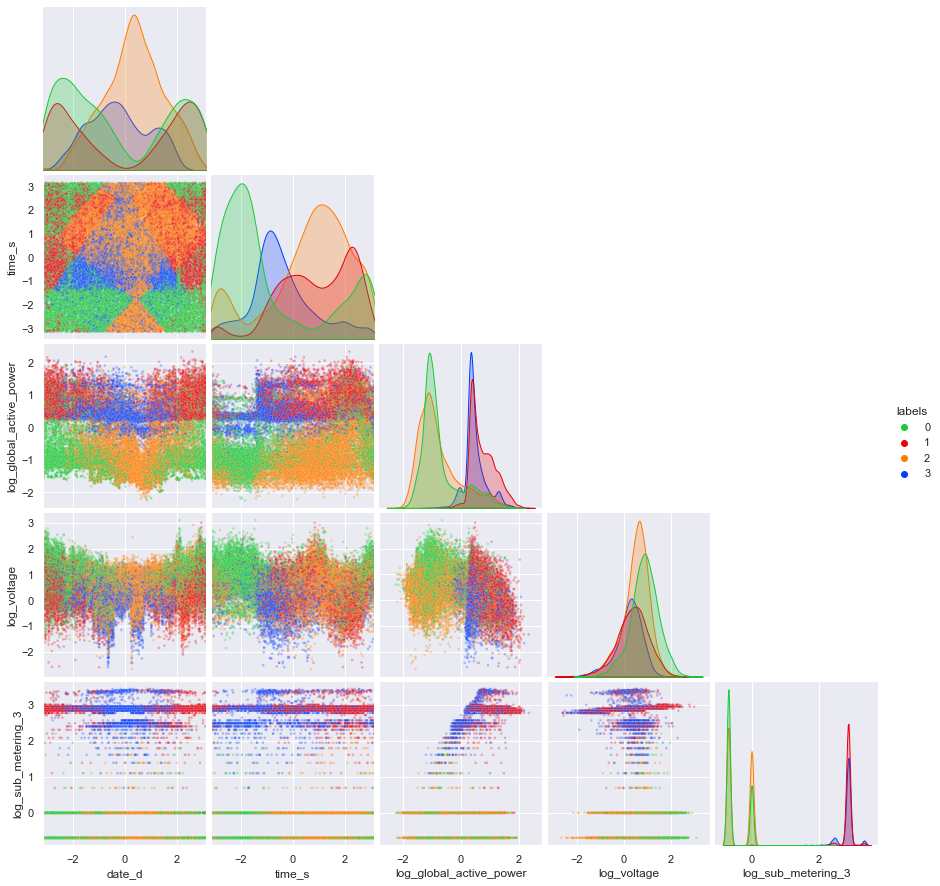

In [28]:
data_sample = data_labeled.sample(n=int(len(data_labeled)/20))
colors = sns.color_palette("bright")
ax = sns.pairplot(data=data_sample, hue='labels',plot_kws={'s':7,'alpha':.3},corner=True,palette=[colors[2],colors[3],colors[1],colors[0]])
ax.axes[4,0].set_xlim((-np.pi,np.pi))
ax.axes[4,1].set_xlim((-np.pi,np.pi))
plt.savefig('periodic_time_date_n4_v2.png')
plt.show()

# Principal component analysis (PCA)
We have used the correlation between the features as a guiding principle in the feature selection. In this section we expect to extract even more relevant information from the data by employing PCA and verify the previous findings. PCA cannot capture the periodicity of the time-related features, so we exclude them from the PCA transformation.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)


# Performance of the models